<div align="right">
    <a href="https://colab.research.google.com/github/Its-Shivanshu-Sharma/HumanPoseDetection/blob/main/HumanPoseDetection.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/>
    </a>
    <br/>
    <a href="https://console.paperspace.com/github/Its-Shivanshu-Sharma/HumanPoseDetection/blob/main/HumanPoseDetection.ipynb">
        <img src="https://assets.paperspace.io/img/gradient-badge.svg" alt="Run on Gradient"/>
    </a>
</div>

## Installing & Importing libraries, packages, etc.

In [1]:
%%bash
pip3 install -qq torch==1.10.2+cu113 torchvision==0.11.3+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

tcmalloc: large alloc 1147494400 bytes == 0x55be3cb5e000 @  0x7fad5eaf0615 0x55be0305117c 0x55be0313147a 0x55be03053f9d 0x55be03145d4d 0x55be030c7ec8 0x55be030c2a2e 0x55be0305588a 0x55be030c7d30 0x55be030c2a2e 0x55be0305588a 0x55be030c4719 0x55be03146b76 0x55be030c3d95 0x55be03146b76 0x55be030c3d95 0x55be03146b76 0x55be030c3d95 0x55be03055ce9 0x55be03099579 0x55be03054902 0x55be030c7c4d 0x55be030c2a2e 0x55be0305588a 0x55be030c4719 0x55be030c2a2e 0x55be0305588a 0x55be030c38f6 0x55be030557aa 0x55be030c3b4f 0x55be030c2a2e
tcmalloc: large alloc 1434370048 bytes == 0x55be811b4000 @  0x7fad5eaf0615 0x55be0305117c 0x55be0313147a 0x55be03053f9d 0x55be03145d4d 0x55be030c7ec8 0x55be030c2a2e 0x55be0305588a 0x55be030c7d30 0x55be030c2a2e 0x55be0305588a 0x55be030c4719 0x55be03146b76 0x55be030c3d95 0x55be03146b76 0x55be030c3d95 0x55be03146b76 0x55be030c3d95 0x55be03055ce9 0x55be03099579 0x55be03054902 0x55be030c7c4d 0x55be030c2a2e 0x55be0305588a 0x55be030c4719 0x55be030c2a2e 0x55be0305588a 0x55be030c

In [2]:
import copy
import os
import pathlib
import time
from functools import partial

import cv2
import pandas as pd
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as T
from google.colab.patches import cv2_imshow
from scipy.io import loadmat
from torch.utils.data import DataLoader, Dataset

cudnn.benchmark = True

## Fetching & Preparing the Dataset

In [3]:
# Set the seed for the RNG(Random Number Generator manually
# (for reproducibility)
torch.manual_seed(10)

### NOTE:
The dataset used in this project is the [`Leeds Sports Pose Dataset`](http://sam.johnson.io/research/lsp.html).

In [4]:
%%bash
# Create a new directory called `pose_dataset` to store the data
mkdir pose_dataset
cd pose_dataset
wget -q http://sam.johnson.io/research/lsp_dataset.zip
unzip -qq lsp_dataset.zip
rm lsp_dataset.zip

In [5]:
root = pathlib.Path("./pose_dataset")

#### The annotations for the joints for each image are in a `joints.mat` file, hence, we make use of the `scipy.io.loadmat` function to read this data.

In [6]:
raw_annotations = loadmat(root / "joints.mat")

In [7]:
raw_annotations_x = raw_annotations["joints"][0].T.reshape(-1, 1).squeeze()
raw_annotations_y = raw_annotations["joints"][1].T.reshape(-1, 1).squeeze()

In [8]:
raw_annotations_x.shape

(28000,)

In [9]:
# No. of joints annotated for each image
n_joints = 14

In [10]:
index = pd.MultiIndex.from_product(
    (range(len(raw_annotations_x) // n_joints), range(n_joints)),
    names=["image_num", "joint"],
)
cols = pd.Index(["x", "y"], name="coordinates")

In [11]:
full_annotations = pd.DataFrame(
    zip(raw_annotations_x, raw_annotations_y), index=index, columns=cols
)
full_annotations

coordinates              x           y
image_num joint                       
0         0      29.746459  143.345440
          1      30.550107  117.226900
          2      28.942812   84.679181
          3      43.006641   85.081005
          4      42.202994  111.199545
...                    ...         ...
1999      9      29.340475   53.940050
          10     18.372023   34.745259
          11     15.172891   11.894317
          12     32.082588   50.283899
          13     40.308927   39.315447

[28000 rows x 2 columns]

In [12]:
full_annotations = full_annotations.unstack(1).swaplevel(i=0, j=1, axis=1).sort_index(axis=1)
full_annotations

joint                0                       1                       2   \
coordinates           x           y           x           y           x   
image_num                                                                 
0             29.746459  143.345440   30.550107  117.226900   28.942812   
1             28.120319  166.655102   49.179443  136.645850   62.604635   
2             40.516958   81.768626   27.965690   50.390458   50.087299   
3             19.627446  137.799656   52.616825  116.356559   41.070542   
4             44.817547  151.488358   51.344251  115.591488   34.374822   
...                 ...         ...         ...         ...         ...   
1995          51.777345  158.725211   57.091984  121.854903   37.162088   
1996          67.076791  162.872997   77.251589  125.000136   50.118793   
1997         120.127452  122.676163  136.330618   98.371414  105.467445   
1998          51.593695  143.630215   33.442430  111.361301   34.114699   
1999          44.422097  174.136003   42.594022  138.488534   42.594022   

joint                           3                      4               ...  \
coordinates           y          x           y          x           y  ...   
image_num                                                              ...   
0             84.679181  43.006641   85.081005  42.202994  111.199545  ...   
1             95.843797  80.241651   96.107036  91.560930  130.854591  ...   
2             68.903577  62.481675   81.297954  60.442094  115.186375  ...   
3             81.305343  48.080786   83.367179  49.317887  116.768926  ...   
4             89.484674  24.584766   87.526663  36.332833  118.202170  ...   
...                 ...        ...         ...        ...         ...  ...   
1995          92.624388  42.144562   90.963563  65.728273  113.882944  ...   
1996          89.953608  35.987129   89.388341  26.942863  125.000136  ...   
1997         101.264836  97.558757   96.635360  72.868218  110.909578  ...   
1998          81.781463  33.442430   84.470539  26.719740  112.033570  ...   
1999         105.583178  33.453645  105.583178  32.539607  142.144685  ...   

joint                9                      10                     11  \
coordinates           x          y           x          y           x   
image_num                                                               
0             50.641292  44.094988   52.650410  58.962464   53.855881   
1             98.668385  53.462309  111.303859  69.783131  109.461186   
2             97.782115  66.550214   92.447826  98.085274   93.546062   
3             53.441560  37.594415   42.720011  61.924083   54.266294   
4             49.386240  50.977124   68.313680  60.114509   78.756406   
...                 ...        ...         ...        ...         ...   
1995          50.448685  46.121296   35.501263  33.166864   21.218171   
1996          41.639795  43.036481   31.464996  69.604010   45.596661   
1997         107.589288  50.726390  115.883766  46.675598  119.548768   
1998          24.702933  39.428514   35.459238  62.957930   29.408816   
1999          29.340475  53.940050   18.372023  34.745259   15.172891   

joint                           12                    13             
coordinates          y           x          y          x          y  
image_num                                                            
0            58.962464   38.184757  36.058514  38.988404  15.565505  
1            96.370275   81.031368  52.672592  83.400520  30.823751  
2            96.359474   95.114970  51.331803  94.330516  29.680867  
3            94.913462   55.503396  30.584172  68.699148  19.450257  
4            45.755761   51.344251  37.923717  52.649591  22.259628  
...                ...         ...        ...        ...        ...  
1995         21.208926   51.777345  44.792637  46.462706  25.527070  
1996         63.951345   64.815725  36.818548  67.076791  22.121617  
1997         38.959805  104.117181  48.797441  93.700860  34.71

In [13]:
def train_val_split(annotations, train_size=None, val_size=None):
    """Function for randomly splitting the annotations into training &
    validation sets as  per the size specified by the parmaters `train_size`
    or `val_size`.
    Indices of training & validation sets are reset to 0. The old indices
    (which specify the image) are stored in a new column named `image_num`.

    Parameters:
    -----------
    - annotations (pandas.DataFrame): Dataframe containing the annotations.
    - train_size (float): Fraction of the data to be allocated to training set.
    - val_size (float): Fraction of the data to be allocated to validation set.
                        This parameter is ignored if `train_size` is not None.

    Returns:
    --------
    Tuple containing the training & validation sets,
    i.e. `(train_annotations, val_annotations)`.

    """
    # Calculate length of training set
    annotation_length = len(annotations)
    if train_size:
        train_len = int(annotation_length * train_size)
    elif val_size:
        train_len = annotation_length - int(annotation_length * val_size)

    # Generate random indices
    rand_idxs = torch.randperm(annotation_length)
    train_annotations = annotations.loc[rand_idxs[:train_len]]
    val_annotations = annotations.loc[rand_idxs[train_len:]]

    # Reset indices of `train_annotations` & `val_annotations` to start from 0
    # (& add `image_num` column)
    train_annotations = train_annotations.reset_index().sort_index(axis=1)
    val_annotations = val_annotations.reset_index().sort_index(axis=1)

    return train_annotations, val_annotations

In [14]:
annotations = {}
annotations["train"], annotations["val"] = train_val_split(
    full_annotations, train_size=0.8
)

In [15]:
for phase in ["train", "val"]:
    print(f"Size of {phase} set: {len(annotations[phase])}")

Size of train set: 1600
Size of val set: 400


### Creating `Dataset` & `DataLoader` objects

In [44]:
class PoseDataset(Dataset):
    def __init__(
        self,
        annotations,
        img_dir,
        img_format="jpg",
        transform=None,
        target_transform=None,
    ):
        """
        Parameters:
        -----------
        - annotations (pandas.DataFrame): Dataframe containing the annotations
                                          for the joints.
        - img_dir (pathlib.Path object or str): Path object or str specifying
                                                the directory containing the
                                                images.
        - img_format (str: default="jpg"): String specifying the format of the
                                           images.
        - transform (callable: default=None): Function or callable which returns
                                              a transformed version of the image
                                              passed as input.
        - target_transform (callable: default=None): Function or callable  which
                                                     returns a transformed
                                                     version of the target label
                                                     passed as input.
        """
        self.annotations = annotations
        self.img_dir = img_dir
        self.img_format = img_format
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        pts = self.annotations.loc[index, slice(0, 13)]
        img_num = self.annotations.loc[index, "image_num"]

        # Append image extension and pad zeros in `img_num` to get the file name
        file_name = f"im{int(img_num)+1:04d}.{self.img_format}"
        img_file = os.path.join(self.img_dir, file_name)
        img = torchvision.io.read_image(img_file).float()

        # Store the original height & width of the images before transformation
        # This will be used for scaling the coordinates of the target points
        org_size = img.size()[-2:]
        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            # Scale the coordinates of the joints after resizing the images
            pts = self.target_transform(pts, org_size)

        return img, pts

In [45]:
def transform_coordinates(pts, org_size, new_size):
    """Function to scale the coordinates in proportion to image resizing.

    Parameters:
    -----------
    - pts (pandas.DataFrame): DataFrame containing the points to be scaled.
    - org_size (tuple or array-like): Original size of the image.
    - new_size (tuple or array-like): Final size of the image after resizing.

    Returns:
    --------
    Numpy ndarray containing the scaled coordinates.
    """
    new_x = pts.loc[:, "x"] * new_size[1] / org_size[1]
    new_y = pts.loc[:, "y"] * new_size[0] / org_size[0]
    new_pts = pd.concat([new_x, new_y], axis=1)

    return torch.Tensor(new_pts.to_numpy().reshape(-1, 1))

In [46]:
img_size = (3, 150, 125)
# Define the mean & standard deviation to use for Normalizing the images
img_mean = [0.485, 0.456, 0.406]
img_std = [0.229, 0.224, 0.225]

In [106]:
data_transforms = {
    "train": nn.Sequential(
        T.Resize(img_size[1:]),
        T.Normalize(img_mean, img_std),
    ),
    "val": nn.Sequential(
        T.Resize(img_size[1:]),
        # T.Normalize(img_mean, img_std),
    ),
}

In [107]:
target_transforms = {
    "train": partial(transform_coordinates, new_size=img_size[1:]),
    "val": partial(transform_coordinates, new_size=img_size[1:]),
}

In [108]:
datasets = {
    phase: PoseDataset(
        annotations=annotations[phase],
        img_dir=root / "images",
        transform=data_transforms[phase],
        target_transform=target_transforms[phase],
    )
    for phase in ["train", "val"]
}

In [109]:
len(datasets["train"]), len(datasets["val"])

(1600, 400)

In [110]:
# Define the batch size
bs = 32
n_workers = 4

In [111]:
dataloaders = {
    phase: DataLoader(
        datasets[phase], batch_size=bs, shuffle=True, num_workers=n_workers
    )
}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Visualizing the Data

In [112]:
joints = [
    "right ankle",
    "right knee",
    "right hip",
    "left hip",
    "left knee",
    "left ankle",
    "right wrist",
    "right elbow",
    "right shoulder",
    "left shoulder",
    "left elbow",
    "left wrist",
    "neck",
    "head top",
]
joints_map = {joint: i for i, joint in enumerate(joints)}

In [113]:
class COLOR:
    """Class containing variables for various colors.
    Color scheme = (B,G,R)
    """

    RED = (0, 0, 255)
    GREEN = (0, 255, 0)
    BLUE = (255, 0, 0)
    CYAN = (255, 255, 0)
    YELLOW = (0, 255, 255)
    MAGENTA = (255, 0, 255)
    LAVENDER = (250, 230, 230)
    ORANGE = (0, 175, 255)

In [114]:
# List of joint-connections & colors being used for connecting the joints in
# image annotations
joints_relations = [
    ("right ankle", "right knee", COLOR.CYAN),
    ("left ankle", "left knee", COLOR.CYAN),
    ("right knee", "right hip", COLOR.RED),
    ("left knee", "left hip", COLOR.RED),
    ("right wrist", "right elbow", COLOR.GREEN),
    ("left wrist", "left elbow", COLOR.GREEN),
    ("right elbow", "right shoulder", COLOR.BLUE),
    ("left elbow", "left shoulder", COLOR.BLUE),
    ("neck", "head top", COLOR.MAGENTA),
    ("neck", "hip line", COLOR.YELLOW),  # hip line = mean of left & right hip
    ("right hip", "left hip", COLOR.LAVENDER),
    ("right shoulder", "left shoulder", COLOR.ORANGE),
]

In [115]:
def annotate_image(img, pts, mapping, relations):
    """Function to annotate an image with lines drawn between specified points.

    Parameters:
    -----------
    - img (torch.Tensor) - Image in (C,H,W) format. Color-scheme = (R,G,B).
    - pts (1d array or tensor) - Points to use for annotating lines.
    - mapping (dict-like) - Mapping from joint name to joint number.
    - relations (list) - List containing tuples defining which points to join &
                         with what color.
    """
    # Change image format from (C, H, W) to (H, W, C)
    img = img.clone().detach().permute((1, 2, 0))

    # Change image from RBG to BGR (& change to np ndarray to show img)
    img = torch.stack((img[:, :, 2], img[:, :, 1], img[:, :, 0]), dim=2).numpy()

    # Change `pts` into a 2d tensor/array
    pts = pts.reshape(-1, 2)

    # Calculate the coordinates for the `hip line` from coordinates of the
    # `right hip` & the `left hip`
    rhip = mapping.get("right hip")
    lhip = mapping.get("left hip")
    # Use floor divison to get integer coordinates (for annotating images)
    hipline_coordinates = (pts[rhip] + pts[lhip]) / 2
    # Change the `hipline_coords` to int (required for annotating the images)
    # And store the coordinates in a tuple instead of a tensor (also required)
    hipline_coordinates = tuple(map(int, hipline_coordinates))

    for j1, j2, color in relations:
        pt1 = mapping.get(j1, None)
        pt2 = mapping.get(j2, None)
        # Convert coordinates to `int` for annotating the image
        # For "hip line" `pt1` or `pt2` will be equal `None` so we set it
        # equal to the above calculated `hipline_coordinates`
        pt1 = tuple(map(int, pts[pt1])) if pt1 is not None else hipline_coordinates
        pt2 = tuple(map(int, pts[pt2])) if pt2 is not None else hipline_coordinates
        # Annotate the image
        cv2.line(img, pt1, pt2, color=color)
    cv2_imshow(img)

## Creating & Training a Model on the Data.

In [116]:
class Model(nn.Module):
    """Class implementing the model to be trained on the data."""

    def __init__(self, img_shape, output_shape):
        super(Model, self).__init__()

        self.img_shape = img_shape
        self.output_shape = output_shape

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=img_shape[0], out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=1),
        )

        self.flatten = nn.Flatten(start_dim=-3)

        # Calculate the shape of the output produced by the convolution &
        # pooling layers
        out_shape = self._calc_output_shape()
        self.fc = nn.Sequential(
            nn.Linear(out_shape[0] * out_shape[1] * out_shape[2], 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_shape),
            nn.ReLU(),
        )

    def forward(self, x):
        y = self.conv(x)
        y = self.flatten(y)
        y = self.fc(y)
        return y

    def _calc_output_shape(self):
        out_img_shape = list(self.img_shape)
        for module in self.conv.modules():
            if isinstance(module, (nn.Conv2d, nn.MaxPool2d, nn.AvgPool2d)):
                # Kernel size
                k = module.kernel_size
                k = k if isinstance(k, tuple) else (k, k)
                # Stride
                s = module.stride
                s = s if isinstance(s, tuple) else (s, s)
                # Padding
                p = module.padding
                p = p if isinstance(p, tuple) else (p, p)
                # Dilation
                d = module.dilation
                d = d if isinstance(d, tuple) else (d, d)
                # Update no. of channels (for Conv2d layers)
                if hasattr(module, "out_channels"):
                    out_img_shape[0] = module.out_channels
                # Update image height
                out_img_shape[1] = (
                    out_img_shape[1] + 2 * p[0] - d[0] * (k[0] - 1) - 1
                ) // s[0] + 1
                # Update image width
                out_img_shape[2] = (
                    out_img_shape[2] + 2 * p[1] - d[1] * (k[1] - 1) - 1
                ) // s[1] + 1

        return out_img_shape

In [117]:
def train_val_model(
    model, dataloaders, loss_fn, optimizer, num_epochs, lr_scheduler=None, device="cpu"
):
    start_time = time.time()

    # Initialize the best model weights as the initial weights of the model
    best_model_parameters = copy.deepcopy(model.state_dict())
    min_val_loss = float("inf")

    # Move the `model` to the specified `device`
    model = model.to(device)

    # Initially set the gradients to zero
    optimizer.grad_zero()

    for i in range(num_epochs):
        print(f"Epoch {i}/{num_epochs-1}")
        print("-" * 15)

        # Both the training & validation datasets are passed to the model in
        # each epoch
        for phase in ["train", "val"]:
            # Set mode depending upon the phase
            if phase == "train":
                model.train()
            else:
                model.eval()

            total_loss = 0.0

            with torch.set_grad_enabled(phase == "train"):
                for imgs, targets in dataloaders["phase"]:
                    imgs = imgs.to(device)
                    targets = targets.to(device)
                    predictions = model(imgs)
                    loss = loss_fn(predictions, targets)
                    total_loss += loss.item() * imgs.size(0)

                    # Update parameter values during the training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        # Set the gradients to zero
                        optimizer.grad_zero()

            # Update the learning rate using the `lr_scheduler`
            # Only count training loops for updating parameters
            if lr_scheduler and phase == "train":
                lr_scheduler.step()
            avg_loss = total_loss / len(datasets[phase])
            print(f"{phase.capitalize()} Average Loss: {avg_loss: .4f}")

            if phase == "val" and avg_loss < min_val_loss:
                best_model_parameters = copy.deepcopy(model.state_dict())
                min_val_loss = avg_loss
        # Print a new line after each epoch
        print()

        total_time = time.time() - start_time
        print(f"Model training completed in {total_time//60}m {total_time % 60}s")
        print(f"Minimum average validation loss: {min_val_loss}")

        return best_model_parameters

##### Use `GPU` for training if available else use `CPU`

In [118]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device being used: {device}")

Device being used: cpu


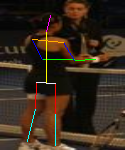

In [119]:
img, pts = datasets["val"][0]
annotate_image(img, pts, joints_map, joints_relations)

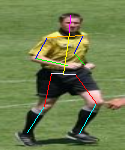

In [122]:
img, pts = datasets["val"][4]
annotate_image(img, pts, joints_map, joints_relations)

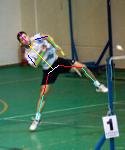

In [123]:
img, pts = datasets["val"][7]
annotate_image(img, pts, joints_map, joints_relations)

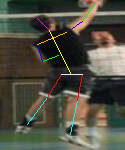

In [124]:
img, pts = datasets["val"][12]
annotate_image(img, pts, joints_map, joints_relations)

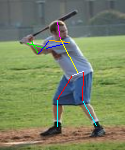

In [127]:
img, pts = datasets["val"][17]
annotate_image(img, pts, joints_map, joints_relations)

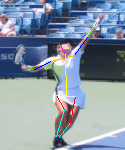

In [136]:
img, pts = datasets["val"][24]
annotate_image(img, pts, joints_map, joints_relations)

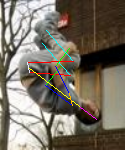

In [138]:
img, pts = datasets["val"][25]
annotate_image(img, pts, joints_map, joints_relations)

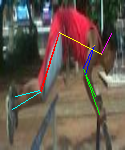

In [143]:
img, pts = datasets["val"][26]
annotate_image(img, pts, joints_map, joints_relations)